In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
import numpy as np
import emcee as em

In [3]:
nwalkers = 20
dim = 5
beta = 0.809523809524
mode = 'pcn'
dist = 'exponential'

fname = './results/data/nwalkers_%s_dim_%s_beta_%s_mode_%s_dist_%s.hdf5' % (nwalkers, dim, beta, mode, dist)
f = h5py.File(fname, 'r+')
dset = f['chain']

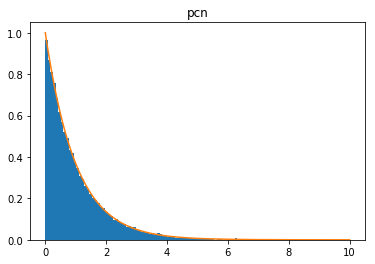

In [5]:
dim_1 = dset[:, :, 0].ravel()
hist=plt.hist(dim_1, bins=100, normed=True)
x = np.linspace(0, 10, 200)
y = np.exp(-x)
plt.plot(x, y)
plt.title(mode)

In [15]:
nwalkers = 20
dim = 5
beta = 0.6
mode = 'ensemble'
dist = 'exponential'

fname = './results/data/nwalkers_%s_dim_%s_beta_%s_mode_%s_dist_%s.hdf5' % (nwalkers, dim, beta, mode, dist)
f = h5py.File(fname, 'r+')
dset = f['chain']

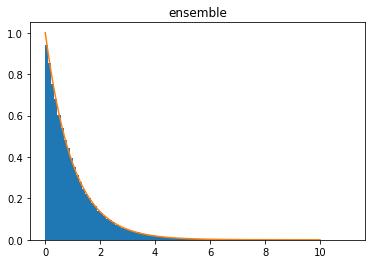

In [6]:
dim_1 = dset[:, :, 0].ravel()
hist=plt.hist(dim_1, bins=100, normed=True)
x = np.linspace(0, 10, 200)
y = np.exp(-x)
plt.plot(x, y)
plt.title(mode)

In [6]:
nwalkers = 20
dim = 5
beta = 0.809523809524
mode = 'gaussian'
dist = 'exponential'

fname = './results/data/nwalkers_%s_dim_%s_beta_%s_mode_%s_dist_%s.hdf5' % (nwalkers, dim, beta, mode, dist)
f = h5py.File(fname, 'r+')
dset = f['chain']

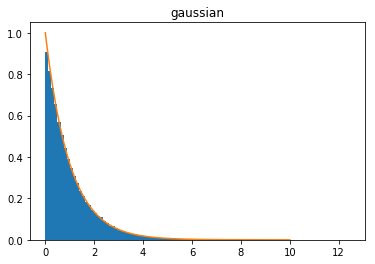

In [7]:
dim_1 = dset[:, :, 0].ravel()
hist=plt.hist(dim_1, bins=100, normed=True)
x = np.linspace(0, 10, 200)
y = np.exp(-x)
plt.plot(x, y)
plt.title(mode)

In [30]:
import emcee

In [3]:
import sys; sys.path.insert(0, '../')
import ensemble_sampler as es
from emcee.autocorr import *

In [ ]:
dim = 2
t_dist = es.Exponential(dim)
proposal = es.Stretch(a=2.0)
nwalkers = 10
niters = 100000

p0 = np.abs(np.random.rand(nwalkers, dim))
rstate0 = np.random.get_state()

n = 10

act_info = np.zeros([2, 2, n])
accept_info = np.zeros([2, 1, n])

for i in range(n):
    act_info[0, :, i], accept_info[0, :, i], _ = emcee_run(nwalkers, dim, t_dist.get_lnprob, niters, p0, rstate0)
    act_info[1, :, i], accept_info[1, :, i], _ = es_run(nwalkers, t_dist, proposal, niters, p0, rstate0)

In [139]:
def emcee_run(nwalkers, dim, lnprobfn, niters, p0, rstate0=None):
    sampler = em.EnsembleSampler(nwalkers, dim, lnprobfn)
    h = sampler.run_mcmc(p0, niters, rstate0=rstate0)
    try:
        auto_corr = sampler.acor
    except AutocorrError:
        auto_corr = np.zeros(dim)
    return [[auto_corr.mean(), np.sqrt(auto_corr.var())],
            sampler.acceptance_fraction.mean(),
            sampler]

def es_run(nwalkers, t_dist, proposal, niters, p0, rstate0=None):
    sampler = es.Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)
    sampler.run_mcmc(niters, p0=p0, rstate0=rstate0)
    try:
        auto_corr = sampler.auto_corr()
    except AutocorrError:
        auto_corr = np.zeros(dim)
    return [[auto_corr.mean(), np.sqrt(auto_corr.var())],
            sampler.acceptance_rate.mean(),
            sampler]

In [175]:
# _, _, sampler = emcee_run(nwalkers, dim, t_dist.get_lnprob, niters, p0, rstate0)
# _, _, sampler = es_run(nwalkers, t_dist, proposal, niters, p0, rstate0)
niters = int(1e6)
# proposal = es.Stretch(a=2.0)
proposal = es.PCNWalk(beta=0.6)
_, _, sampler = es_run(nwalkers, t_dist, proposal, niters, p0, rstate0)

In [176]:
history = sampler.chain
x = np.expand_dims(history[:, :, 0], 1)
y = np.expand_dims(history[:, :, 1], 1)

In [177]:
moments = np.concatenate([x, y,
                        (x**2), (x*y), (y**2),
                        (x**3), (x**2*y), (x*y**2), (y**3),
                        (x**4), (x**3*y), (x**2*y**2), (x*y**3), (y**4)], axis=1)
gt = np.array([1, 1, 2, 1, 2, 6, 2, 2, 6, 24, 6, 4, 6, 24])

In [178]:
print 'moment diff: ', np.abs(avg_moments - gt).sum()
print 'act: ', sampler.auto_corr()

moment diff:  0.378960411869
act:  [ 146.14585938  134.74245171]


In [179]:
avg_moments = moments.mean(2).mean(0)
print '(x, y): ', avg_moments[:2] 
print '(xx, xy, yy): ', avg_moments[2:5] 
print '(xxx, xxy, xyy, yyy): ', avg_moments[5:9] 
print '(xxxx, xxxy, xxyy, xyyy, yyyy): ', avg_moments[9:] 

moments after sweep 1: 
(x, y):  [ 1.00344241  0.99152989]
(xx, xy, yy):  [ 2.01541116  0.99573123  1.94584278]
(xxx, xxy, xyy, yyy):  [ 6.0798909   1.9959802   1.95284885  5.6371371 ]
(xxxx, xxxy, xxyy, xyyy, yyyy):  [ 24.38066317   5.97171825   3.8940008    5.6373384   21.29268301]
